<a href="https://colab.research.google.com/github/tmor8832/NaturalLanguageProcessing/blob/master/Live_Tweet_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
#This code will connect to twitter API and monitor real time tweets for key words and phrases. Written by Thomas Morris

In [73]:
#import the relevant libraries
import tweepy #used to access twitter API
from textblob import TextBlob #used for common NLP tasks and analysis
from wordcloud import WordCloud #for generating a wordcloud image
import pandas as pd #used for creating dataframes
import numpy as np #arrays etc
import seaborn as sns #graphical library
import itertools #used for nice loops and iterations
import collections
import re #regular expressions, useful for NLP
import json
import matplotlib.pyplot as plt #useful for visualisation of data
plt.style.use('fivethirtyeight')

In [74]:
#Store all functions in this section

#Extract the data from the CSV file and store as variables
def credentials(log):
  ConsumerKey = log['key'][0]
  ConsumerKeySecret = log['key'][1]
  AccessToken = log['key'][3]
  AccessTokenSecret = log['key'][4]
  api = authenticate(ConsumerKey, ConsumerKeySecret, AccessToken, AccessTokenSecret)
  return api

#Create the authentication object to connect to the twitter API
def authenticate(ConsumerKey, ConsumerKeySecret, AccessToken, AccessTokenSecret): 
  authenticate = tweepy.OAuthHandler(ConsumerKey, ConsumerKeySecret)
  authenticate.set_access_token(AccessToken, AccessTokenSecret)
  api = tweepy.API(authenticate, wait_on_rate_limit=True)
  return api


#Clean the tweets to remove unwanted characters and data
def cleanTweet (tweet):
  tweet = re.sub('#bitcoin', 'bitcoin', tweet) #Remove hashtag from bitcoin or Bitcoin
  tweet = re.sub('#Bitcoin', 'Bitcoin', tweet) #Adjust this as needed for the specific search term
  tweet = re.sub('#[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('@[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('$[A-Za-z0-9]+', '', tweet) #Remove any strings with a hashtag
  tweet = re.sub('[!,*)@#%(&$_?.^]', '', tweet)
  tweet = re.sub('\\n', '', tweet) #removing the '\n' string
  tweet = re.sub('https', '', tweet) #remove any hyperlinks
  tweet = re.sub('http', '', tweet) #remove any hyperlinks
  return tweet

def cleanTweetofCommon (tweet):
  tweet = tweet.lower()
  tweet = re.sub('and', '', tweet) 
  tweet = re.sub('or', '', tweet) 
  tweet = re.sub('it', '', tweet) 
  tweet = re.sub('of', '', tweet) 
  tweet = re.sub('the', '', tweet) 
  tweet = re.sub('to', '', tweet)
  tweet = re.sub('a', '', tweet) 
  tweet = re.sub('is', '', tweet) 
  tweet = re.sub('it', '', tweet) 
  tweet = re.sub('ok', '', tweet) 
  tweet = re.sub('but', '', tweet)
  tweet = re.sub('in', '', tweet)
  tweet = re.sub('got', '', tweet) 
  return tweet

# Use of textblob NLTK lib https://towardsdatascience.com/my-absolute-go-to-for-sentiment-analysis-textblob-3ac3a11d524
#create a function to get the subjectivity, values between 0 and 1 where 1 is a high degree of personal opinion and not fact
def getSubjectivity(tweet):
  return TextBlob(tweet).sentiment.subjectivity

#create a function to get the polarity, values bwteen [-1:1] -1 is negative, 1 is a positive sentiment
def getPolarity(tweet):
  return TextBlob(tweet).sentiment.polarity 

#create a function to get the sentiment text
def getSentiment(score):
  if score < 0:
    return 'Negative'
  elif score == 0:
    return 'Neutral'
  else:
    return 'Positive' 

In [75]:
from google.colab import files
files.upload()
log = pd.read_csv('Login.csv')

Saving Login.csv to Login (1).csv


In [76]:
#override tweepy.StreamListener to add logic to on_status
# Guidance for using stream at https://www.dataquest.io/blog/streaming-data-python/
api = credentials(log)
tweet_text = []
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
      if 'and' in status.text.lower(): #this could be used to further filter words within a location (only way to apply AND logic to filtering)
            print(status.text)
            tweet_text.append(status.text)
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
    def on_timeout(self):
      return True  # Don't kill the stream
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth=api.auth, listener=myStreamListener)
myStream.filter(locations=[-122.75,36.8,-121.75,37.8,-74,40,-73,41]) #Filter tweets by location determined by coordinates (SAN FRAN or NEW YORK)
#MyStream.filter(track=['star wars']) #use this to filter tweets by key words

@lilpineycone Smokey and Paco is ready for the event https://t.co/wmIheqGsy7
@hourlyspears We love a free Britney and she is free
Happy Birthday to my bestie @smokedarapper 

May God bless you and spot His light on your path to greatness.  Time… https://t.co/Rf4yfBLVJg
gm ☀️

Today's plan is to have the best brunch at @Hobees MTV with @jSheely and @YourETHGirl, show them around… https://t.co/8cvpJc3jGD
.@pissbloc is the best thing on the planet next to @LitterPdx and then @retconmike’s lil PayPal x
First time using my Byredo perfume and let me just say, it compliments me soooo well 😌


KeyboardInterrupt: ignored

In [77]:
#Create a dataframe to hold the tweets and then clean the tweets of unwanted info using the pre written function
df = pd.DataFrame(tweet_text, columns =['Tweets'])
df['Tweets'] = df['Tweets'].apply(cleanTweet)
df.head()
clean_tweet_list = [cleanTweetofCommon(tweet) for tweet in tweet_text]
words_in_tweet = [tweet.lower().split() for tweet in clean_tweet_list]
clean_tweet_list = list(itertools.chain(*words_in_tweet)) #iterate through each word in each tweet
#Create counter and get most common words
count = collections.Counter(clean_tweet_list) 
clean_tweet_list = pd.DataFrame(count.most_common(15), columns=['words', 'count']) #create DF to store most common words and count of each

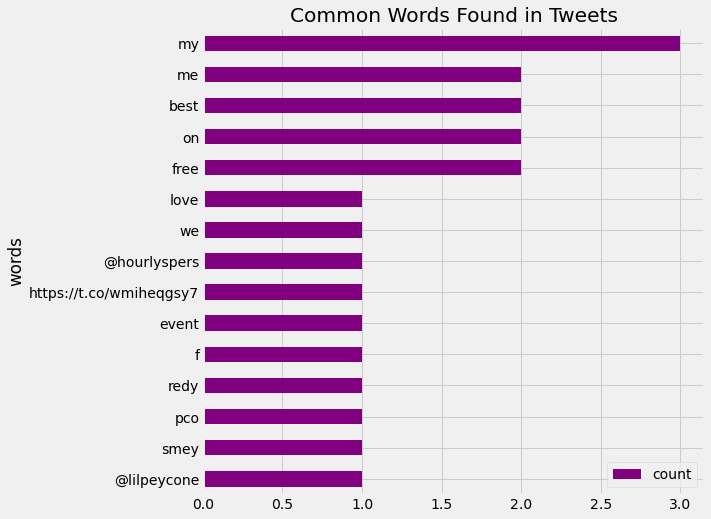

In [78]:
#Visualise the data - word count plot of data
fig, ax = plt.subplots(figsize=(8, 8))
# Plot horizontal bar graph
clean_tweet_list.sort_values(by='count').plot.barh(x='words',  y='count',ax=ax,color="purple")
ax.set_title("Common Words Found in Tweets")
plt.show()

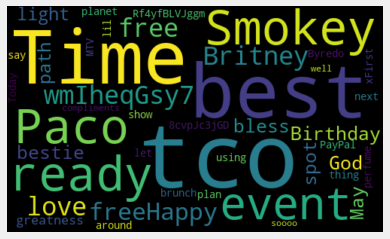

In [79]:
#Plot a word cloud
allWords = ''.join([twts for twts in df['Tweets']])
wordcloud = WordCloud(width = 500, height = 300, random_state= 21, max_font_size=119).generate(allWords)
plt.imshow(wordcloud, interpolation= 'bilinear')
plt.axis('off')
plt.show()

In [80]:
#Now do sentiment analysis on the tweets to determine sentiment 

In [81]:
df['Subjectivity'] = df['Tweets'].apply(getSubjectivity) #df to hold subjectivity
df['Polarity'] = df['Tweets'].apply(getPolarity)#df to hold polarity
df['Sentiment'] = df['Polarity'].apply(getSentiment) #create a column to store the text sentiment

#print positive tweets
j=1
sortedDF = df.sort_values(by=['Polarity'])
for i in range (0, sortedDF.shape[0]):
  if (sortedDF['Sentiment'][i]=='Positive'):
    print(str(j) + ')' + sortedDF['Tweets'][i])
    print()
    j = j+1

1) Smokey and Paco is ready for the event ://tco/wmIheqGsy7

2) We love a free Britney and she is free

3)Happy Birthday to my bestie  May God bless you and spot His light on your path to greatness  Time… ://tco/Rf4yfBLVJg

4)gm ☀️Today's plan is to have the best brunch at  MTV with  and  show them around… ://tco/8cvpJc3jGD

5) is the best thing on the planet next to  and then ’s lil PayPal x

6)First time using my Byredo perfume and let me just say it compliments me soooo well 😌



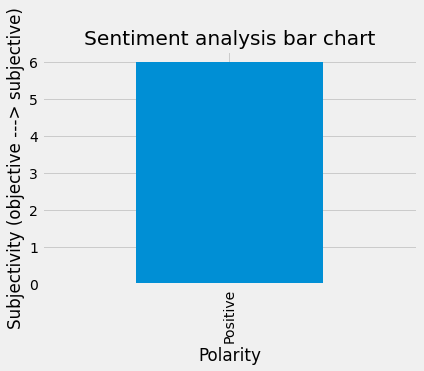

In [82]:
#Visualise the sentiment analysis data, how many of each type of tweet was there
df['Sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment analysis bar chart')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity (objective ---> subjective)')
plt.show()